In [53]:
!git clone https://github.com/JonasGeiping/invertinggradients.git
import sys
sys.path.insert(0,'invertinggradients')

fatal: destination path 'invertinggradients' already exists and is not an empty directory.


In [55]:
import inversefed
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn

from torchvision import datasets, models, transforms
from torchvision.models.resnet import Bottleneck
from collections import OrderedDict
#from google.colab import drive
from collections import defaultdict
from PIL import Image

#drive.mount('/content/drive')

# Choose variants here:

## System setup:

In [3]:
model = models.densenet121(pretrained=True) # we will use a pretrained model and we are going to change only the last layer
for param in model.parameters():
    param.requires_grad = True

model.classifier = nn.Sequential(OrderedDict([
    ('fcl1', nn.Linear(1024,256)),
    ('dp1', nn.Dropout(0.1)),
    ('r1', nn.ReLU()),
    ('fcl2', nn.Linear(256,32)),
    ('dp2', nn.Dropout(0.1)),
    ('r2', nn.ReLU()),
    ('fcl3', nn.Linear(32,2)),
    ('out', nn.LogSoftmax(dim=1)),
]))

model.to('cuda:0')

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [56]:
inversefed.utils.set_random_seed(0)
setup = inversefed.utils.system_startup()

model.to(**setup)
#model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/saved_state.pth'))
model.load_state_dict(torch.load('../modelos/0-87_0-315.pth'))    
model.eval(); 

Currently evaluating -------------------------------:
Monday, 20. March 2023 11:23AM
CPUs: 6, GPUs: 1 on aml-kaggle-ddelriod.
GPU : Tesla K80


In [57]:
def plot(tensor):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    if tensor.shape[0] == 1:
        return plt.imshow(tensor[0].permute(1, 2, 0).cpu());
    else:
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(12, tensor.shape[0]*12))
        for i, im in enumerate(tensor):
            axes[i].imshow(im.permute(1, 2, 0).cpu());

# Reconstruct

### Build the input (ground-truth) gradient

In [60]:
data_dir = {
            'train': './reconstruct-samples/train',
            'test': './reconstruct-samples/test',
            'valid': './reconstruct-samples/val'
            } 

data_dir = {
            'train': '/content/drive/MyDrive/Colab Notebooks/chest_xray/train',
            'test': '/content/drive/MyDrive/Colab Notebooks/chest_xray/test',
            'valid': '/content/drive/MyDrive/Colab Notebooks/chest_xray/val'
            } 

In [61]:
batch_size = 32 # we will set the batch size to 64 

data_transforms = {
            'train': transforms.Compose([
                        transforms.Resize((224, 224)),
                        #transforms.CenterCrop(224),
                        #transforms.RandomHorizontalFlip(), # randomly flip and rotate
                        #transforms.RandomRotation(10),
                        transforms.ToTensor(),
                        #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ]),
    
            'test': transforms.Compose([
                        transforms.Resize((224,224)),
                        transforms.ToTensor(),
                        #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ]),
    
            'valid': transforms.Compose([
                        transforms.Resize((224,224)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ])
            }
# Load the datasets with ImageFolder

data_set={
        'train': torchvision.datasets.ImageFolder(data_dir['train'] ,data_transforms['train']),
        'test': torchvision.datasets.ImageFolder(data_dir['test'], data_transforms['test']),
        'valid': torchvision.datasets.ImageFolder(data_dir['valid'], data_transforms['valid']),
         }

# Using the image datasets and the trainforms, define the dataloaders
data_loader={
        'train': torch.utils.data.DataLoader(data_set['train'], batch_size=batch_size,shuffle=False),
        'test': torch.utils.data.DataLoader(data_set['test'], batch_size=batch_size,shuffle=False),
        'valid': torch.utils.data.DataLoader(data_set['valid'], batch_size=batch_size,shuffle=False),
        }

In [ ]:
num_images=1
if num_images == 1:
    ground_truth_image = torch.as_tensor(np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg").resize((224, 224), Image.BICUBIC)) / 255, 
                                         **setup).unsqueeze(0).to('cuda:0')
    ground_truth = ground_truth_image.sub(dm).div(ds).unsqueeze(0).contiguous()
    labels = torch.as_tensor((1,), device=setup['device'])
else:
    ground_truth, labels = [], []
    idx = 25 # choosen randomly ... just whatever you want
    while len(labels) < num_images:
        img, label = validloader.dataset[idx]
        idx += 1
        if label not in labels:
            labels.append(torch.as_tensor((label,), device=setup['device']))
            ground_truth.append(img.to(**setup))
    ground_truth = torch.stack(ground_truth)
    labels = torch.cat(labels)

In [62]:
dataiter = iter(data_loader['train']) #antes era la de test
images, labels = next(dataiter)
images, labels = images.cuda(), labels.cuda()

In [63]:
criterion = nn.NLLLoss()
output = model(images[0].unsqueeze(0))
labels = labels[0].unsqueeze(0)
target_loss = criterion(output, labels)

In [64]:
model.zero_grad()
input_gradient = torch.autograd.grad(target_loss, model.parameters())
input_gradient = [grad.detach() for grad in input_gradient]

In [66]:
config = dict(signed=True,
              boxed=True,
              cost_fn='sim',
              indices='def',
              weights='equal',
              lr=0.1, #default 0.1, antes 0.05 y 0.075 no va mal
              optim='sgd',#ojo con sgd
              restarts=1,
              max_iterations=50000,
              total_variation=1e-6, #default6
              init='randn',
              filter='none',
              lr_decay=True,
              scoring_choice='loss')

num_images = 1
dm_values = [0.485, 0.456, 0.406]
ds_values = [0.229, 0.224, 0.225]
dm = torch.tensor(dm_values).unsqueeze(1).unsqueeze(1).cuda()
ds = torch.tensor(ds_values).unsqueeze(1).unsqueeze(1).cuda()

rec_machine = inversefed.GradientReconstructor(model, (dm, ds), config, num_images=num_images)
output, stats = rec_machine.reconstruct(input_gradient, labels, img_shape=(3, 224, 224))

test_mse = (output.detach() - images[0]).pow(2).mean()
feat_mse = (model(output.detach())- model(images[0])).pow(2).mean()  
test_psnr = inversefed.metrics.psnr(output, images[0], factor=1/ds)

plot(output)
plt.title(f"Rec. loss: {stats['opt']:2.4f} | MSE: {test_mse:2.4f} "
          f"| PSNR: {test_psnr:4.2f} | FMSE: {feat_mse:2.4e} |");

It: 0. Rec. loss: 0.9451.
It: 500. Rec. loss: 0.6939.
It: 1000. Rec. loss: 0.7162.
It: 1500. Rec. loss: 0.7169.
It: 2000. Rec. loss: 0.7016.
It: 2500. Rec. loss: 0.7142.
It: 3000. Rec. loss: 0.6901.
It: 3500. Rec. loss: 0.7071.
It: 4000. Rec. loss: 0.6965.
It: 4500. Rec. loss: 0.6937.
It: 5000. Rec. loss: 0.7103.
It: 5500. Rec. loss: 0.7197.
It: 6000. Rec. loss: 0.7031.


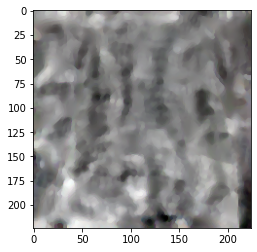

In [40]:
plot(output)

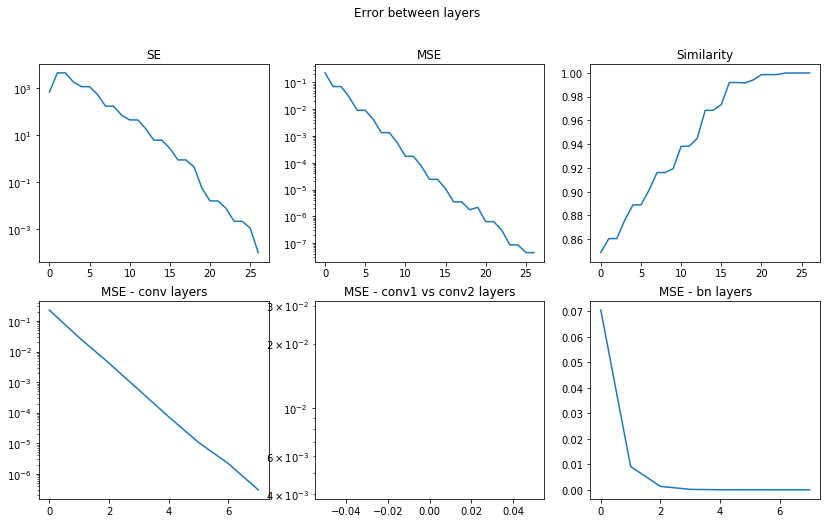

In [ ]:
data = inversefed.metrics.activation_errors(model, output, ground_truth)

fig, axes = plt.subplots(2, 3, sharey=False, figsize=(14,8))
axes[0, 0].semilogy(list(data['se'].values())[:-3])
axes[0, 0].set_title('SE')
axes[0, 1].semilogy(list(data['mse'].values())[:-3])
axes[0, 1].set_title('MSE')
axes[0, 2].plot(list(data['sim'].values())[:-3])
axes[0, 2].set_title('Similarity')

convs = [val for key, val in data['mse'].items() if 'conv' in key]
axes[1, 0].semilogy(convs)
axes[1, 0].set_title('MSE - conv layers')
convs = [val for key, val in data['mse'].items() if 'conv1' in key]
axes[1, 1].semilogy(convs)
convs = [val for key, val in data['mse'].items() if 'conv2' in key]
axes[1, 1].semilogy(convs)
axes[1, 1].set_title('MSE - conv1 vs conv2 layers')
bns = [val for key, val in data['mse'].items() if 'bn' in key]
axes[1, 2].plot(bns)
axes[1, 2].set_title('MSE - bn layers')
fig.suptitle('Error between layers');

In [65]:
"""Mechanisms for image reconstruction from parameter gradients."""

import torch
from collections import defaultdict, OrderedDict
from inversefed.nn import MetaMonkey
from inversefed.metrics import total_variation as TV
from inversefed.metrics import InceptionScore
from inversefed.medianfilt import MedianPool2d
from copy import deepcopy

import time

DEFAULT_CONFIG = dict(signed=False,
                      boxed=True,
                      cost_fn='sim',
                      indices='def',
                      weights='equal',
                      lr=0.1,
                      optim='adam',
                      restarts=1,
                      max_iterations=4800,
                      total_variation=1e-1,
                      init='randn',
                      filter='none',
                      lr_decay=True,
                      scoring_choice='loss')

def _label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def _validate_config(config):
    for key in DEFAULT_CONFIG.keys():
        if config.get(key) is None:
            config[key] = DEFAULT_CONFIG[key]
    for key in config.keys():
        if DEFAULT_CONFIG.get(key) is None:
            raise ValueError(f'Deprecated key in config dict: {key}!')
    return config


class GradientReconstructor():
    """Instantiate a reconstruction algorithm."""

    def __init__(self, model, mean_std=(0.0, 1.0), config=DEFAULT_CONFIG, num_images=1):
        """Initialize with algorithm setup."""
        self.config = _validate_config(config)
        self.model = model
        self.setup = dict(device=next(model.parameters()).device, dtype=next(model.parameters()).dtype)

        self.mean_std = mean_std
        self.num_images = num_images

        if self.config['scoring_choice'] == 'inception':
            self.inception = InceptionScore(batch_size=1, setup=self.setup)

        self.loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
        self.iDLG = True

    def reconstruct(self, input_data, labels, img_shape=(3, 32, 32), dryrun=False, eval=True, tol=None):
        """Reconstruct image from gradient."""
        start_time = time.time()
        if eval:
            self.model.eval()


        stats = defaultdict(list)
        x = self._init_images(img_shape)
        scores = torch.zeros(self.config['restarts'])

        if labels is None:
            if self.num_images == 1 and self.iDLG:
                # iDLG trick:
                last_weight_min = torch.argmin(torch.sum(input_data[-2], dim=-1), dim=-1)
                labels = last_weight_min.detach().reshape((1,)).requires_grad_(False)
                self.reconstruct_label = False
            else:
                # DLG label recovery
                # However this also improves conditioning for some LBFGS cases
                self.reconstruct_label = True

                def loss_fn(pred, labels):
                    labels = torch.nn.functional.softmax(labels, dim=-1)
                    return torch.mean(torch.sum(- labels * torch.nn.functional.log_softmax(pred, dim=-1), 1))
                self.loss_fn = loss_fn
        else:
            assert labels.shape[0] == self.num_images
            self.reconstruct_label = False

        try:
            for trial in range(self.config['restarts']):
                x_trial, labels = self._run_trial(x[trial], input_data, labels, dryrun=dryrun)
                # Finalize
                scores[trial] = self._score_trial(x_trial, input_data, labels)
                x[trial] = x_trial
                if tol is not None and scores[trial] <= tol:
                    break
                if dryrun:
                    break
        except KeyboardInterrupt:
            print('Trial procedure manually interruped.')
            pass

        # Choose optimal result:
        if self.config['scoring_choice'] in ['pixelmean', 'pixelmedian']:
            x_optimal, stats = self._average_trials(x, labels, input_data, stats)
        else:
            print('Choosing optimal result ...')
            scores = scores[torch.isfinite(scores)]  # guard against NaN/-Inf scores?
            optimal_index = torch.argmin(scores)
            print(f'Optimal result score: {scores[optimal_index]:2.4f}')
            stats['opt'] = scores[optimal_index].item()
            x_optimal = x[optimal_index]

        print(f'Total time: {time.time()-start_time}.')
        return x_optimal.detach(), stats

    def _init_images(self, img_shape):
        if self.config['init'] == 'randn':
            return torch.randn((self.config['restarts'], self.num_images, *img_shape), **self.setup)
        elif self.config['init'] == 'rand':
            return (torch.rand((self.config['restarts'], self.num_images, *img_shape), **self.setup) - 0.5) * 2
        elif self.config['init'] == 'zeros':
            return torch.zeros((self.config['restarts'], self.num_images, *img_shape), **self.setup)
        else:
            raise ValueError()

    def _run_trial(self, x_trial, input_data, labels, dryrun=False):
        x_trial.requires_grad = True
        if self.reconstruct_label:
            output_test = self.model(x_trial)
            labels = torch.randn(output_test.shape[1]).to(**self.setup).requires_grad_(True)

            if self.config['optim'] == 'adam':
                optimizer = torch.optim.Adam([x_trial, labels], lr=self.config['lr'])
            elif self.config['optim'] == 'sgd':  # actually gd
                optimizer = torch.optim.SGD([x_trial, labels], lr=0.01, momentum=0.9, nesterov=True)
            elif self.config['optim'] == 'LBFGS':
                optimizer = torch.optim.LBFGS([x_trial, labels])
            else:
                raise ValueError()
        else:
            if self.config['optim'] == 'adam':
                optimizer = torch.optim.Adam([x_trial], lr=self.config['lr'])
            elif self.config['optim'] == 'sgd':  # actually gd
                optimizer = torch.optim.SGD([x_trial], lr=0.01, momentum=0.9, nesterov=True)
            elif self.config['optim'] == 'LBFGS':
                optimizer = torch.optim.LBFGS([x_trial])
            else:
                raise ValueError()

        max_iterations = self.config['max_iterations']
        dm, ds = self.mean_std
        if self.config['lr_decay']:
            scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                             milestones=[max_iterations // 4.5,
                                                                         max_iterations // 2.25,
                                                                         max_iterations // 1.5,
                                                                         max_iterations // 1.125], gamma=0.25)  
        try:
            for iteration in range(max_iterations):
                closure = self._gradient_closure(optimizer, x_trial, input_data, labels)
                rec_loss = optimizer.step(closure)
                if self.config['lr_decay']:
                    scheduler.step()

                with torch.no_grad():
                    # Project into image space
                    if self.config['boxed']:
                        x_trial.data = torch.max(torch.min(x_trial, (1 - dm) / ds), -dm / ds)

                    if (iteration + 1 == max_iterations) or iteration % 500 == 0:
                        print(f'It: {iteration}. Rec. loss: {rec_loss.item():2.4f}.')

                    if (iteration + 1) % 500 == 0:
                        if self.config['filter'] == 'none':
                            pass
                        elif self.config['filter'] == 'median':
                            x_trial.data = MedianPool2d(kernel_size=3, stride=1, padding=1, same=False)(x_trial)
                        else:
                            raise ValueError()

                if dryrun:
                    break
        except KeyboardInterrupt:
            print(f'Recovery interrupted manually in iteration {iteration}!')
            pass
        return x_trial.detach(), labels

    def _gradient_closure(self, optimizer, x_trial, input_gradient, label):

        def closure():
            optimizer.zero_grad()
            self.model.zero_grad()
            loss = self.loss_fn(self.model(x_trial), label)
            gradient = torch.autograd.grad(loss, self.model.parameters(), create_graph=True)
            rec_loss = reconstruction_costs([gradient], input_gradient,
                                            cost_fn=self.config['cost_fn'], indices=self.config['indices'],
                                            weights=self.config['weights'])

            if self.config['total_variation'] > 0:
                rec_loss += self.config['total_variation'] * TV(x_trial)
            rec_loss.backward()
            if self.config['signed']:
                x_trial.grad.sign_()
            return rec_loss
        return closure

    def _score_trial(self, x_trial, input_gradient, label):
        if self.config['scoring_choice'] == 'loss':
            self.model.zero_grad()
            x_trial.grad = None
            loss = self.loss_fn(self.model(x_trial), label)
            gradient = torch.autograd.grad(loss, self.model.parameters(), create_graph=False)
            return reconstruction_costs([gradient], input_gradient,
                                        cost_fn=self.config['cost_fn'], indices=self.config['indices'],
                                        weights=self.config['weights'])
        elif self.config['scoring_choice'] == 'tv':
            return TV(x_trial)
        elif self.config['scoring_choice'] == 'inception':
            # We do not care about diversity here!
            return self.inception(x_trial)
        elif self.config['scoring_choice'] in ['pixelmean', 'pixelmedian']:
            return 0.0
        else:
            raise ValueError()

    def _average_trials(self, x, labels, input_data, stats):
        print(f'Computing a combined result via {self.config["scoring_choice"]} ...')
        if self.config['scoring_choice'] == 'pixelmedian':
            x_optimal, _ = x.median(dim=0, keepdims=False)
        elif self.config['scoring_choice'] == 'pixelmean':
            x_optimal = x.mean(dim=0, keepdims=False)

        self.model.zero_grad()
        if self.reconstruct_label:
            labels = self.model(x_optimal).softmax(dim=1)
        loss = self.loss_fn(self.model(x_optimal), labels)
        gradient = torch.autograd.grad(loss, self.model.parameters(), create_graph=False)
        stats['opt'] = reconstruction_costs([gradient], input_data,
                                            cost_fn=self.config['cost_fn'],
                                            indices=self.config['indices'],
                                            weights=self.config['weights'])
        print(f'Optimal result score: {stats["opt"]:2.4f}')
        return x_optimal, stats



class FedAvgReconstructor(GradientReconstructor):
    """Reconstruct an image from weights after n gradient descent steps."""

    def __init__(self, model, mean_std=(0.0, 1.0), local_steps=2, local_lr=1e-4,
                 config=DEFAULT_CONFIG, num_images=1, use_updates=True, batch_size=0):
        """Initialize with model, (mean, std) and config."""
        super().__init__(model, mean_std, config, num_images)
        self.local_steps = local_steps
        self.local_lr = local_lr
        self.use_updates = use_updates
        self.batch_size = batch_size

    def _gradient_closure(self, optimizer, x_trial, input_parameters, labels):
        def closure():
            optimizer.zero_grad()
            self.model.zero_grad()
            parameters = loss_steps(self.model, x_trial, labels, loss_fn=self.loss_fn,
                                    local_steps=self.local_steps, lr=self.local_lr,
                                    use_updates=self.use_updates,
                                    batch_size=self.batch_size)
            rec_loss = reconstruction_costs([parameters], input_parameters,
                                            cost_fn=self.config['cost_fn'], indices=self.config['indices'],
                                            weights=self.config['weights'])

            if self.config['total_variation'] > 0:
                rec_loss += self.config['total_variation'] * TV(x_trial)
            rec_loss.backward()
            if self.config['signed']:
                x_trial.grad.sign_()
            return rec_loss
        return closure

    def _score_trial(self, x_trial, input_parameters, labels):
        if self.config['scoring_choice'] == 'loss':
            self.model.zero_grad()
            parameters = loss_steps(self.model, x_trial, labels, loss_fn=self.loss_fn,
                                    local_steps=self.local_steps, lr=self.local_lr, use_updates=self.use_updates)
            return reconstruction_costs([parameters], input_parameters,
                                        cost_fn=self.config['cost_fn'], indices=self.config['indices'],
                                        weights=self.config['weights'])
        elif self.config['scoring_choice'] == 'tv':
            return TV(x_trial)
        elif self.config['scoring_choice'] == 'inception':
            # We do not care about diversity here!
            return self.inception(x_trial)


def loss_steps(model, inputs, labels, loss_fn=torch.nn.CrossEntropyLoss(), lr=1e-4, local_steps=4, use_updates=True, batch_size=0):
    """Take a few gradient descent steps to fit the model to the given input."""
    patched_model = MetaMonkey(model)
    if use_updates:
        patched_model_origin = deepcopy(patched_model)
    for i in range(local_steps):
        if batch_size == 0:
            outputs = patched_model(inputs, patched_model.parameters)
            labels_ = labels
        else:
            idx = i % (inputs.shape[0] // batch_size)
            outputs = patched_model(inputs[idx * batch_size:(idx + 1) * batch_size], patched_model.parameters)
            labels_ = labels[idx * batch_size:(idx + 1) * batch_size]
        loss = loss_fn(outputs, labels_).sum()
        grad = torch.autograd.grad(loss, patched_model.parameters.values(),
                                   retain_graph=True, create_graph=True, only_inputs=True)

        patched_model.parameters = OrderedDict((name, param - lr * grad_part)
                                               for ((name, param), grad_part)
                                               in zip(patched_model.parameters.items(), grad))

    if use_updates:
        patched_model.parameters = OrderedDict((name, param - param_origin)
                                               for ((name, param), (name_origin, param_origin))
                                               in zip(patched_model.parameters.items(), patched_model_origin.parameters.items()))
    return list(patched_model.parameters.values())


def reconstruction_costs(gradients, input_gradient, cost_fn='l2', indices='def', weights='equal'):
    """Input gradient is given data."""
    if isinstance(indices, list):
        pass
    elif indices == 'def':
        indices = torch.arange(len(input_gradient))
    elif indices == 'batch':
        indices = torch.randperm(len(input_gradient))[:8]
    elif indices == 'topk-1':
        _, indices = torch.topk(torch.stack([p.norm() for p in input_gradient], dim=0), 4)
    elif indices == 'top10':
        _, indices = torch.topk(torch.stack([p.norm() for p in input_gradient], dim=0), 10)
    elif indices == 'top50':
        _, indices = torch.topk(torch.stack([p.norm() for p in input_gradient], dim=0), 50)
    elif indices in ['first', 'first4']:
        indices = torch.arange(0, 4)
    elif indices == 'first5':
        indices = torch.arange(0, 5)
    elif indices == 'first10':
        indices = torch.arange(0, 10)
    elif indices == 'first50':
        indices = torch.arange(0, 50)
    elif indices == 'last5':
        indices = torch.arange(len(input_gradient))[-5:]
    elif indices == 'last10':
        indices = torch.arange(len(input_gradient))[-10:]
    elif indices == 'last50':
        indices = torch.arange(len(input_gradient))[-50:]
    else:
        raise ValueError()

    ex = input_gradient[0]
    if weights == 'linear':
        weights = torch.arange(len(input_gradient), 0, -1, dtype=ex.dtype, device=ex.device) / len(input_gradient)
    elif weights == 'exp':
        weights = torch.arange(len(input_gradient), 0, -1, dtype=ex.dtype, device=ex.device)
        weights = weights.softmax(dim=0)
        weights = weights / weights[0]
    else:
        weights = input_gradient[0].new_ones(len(input_gradient))

    total_costs = 0
    for trial_gradient in gradients:
        pnorm = [0, 0]
        costs = 0
        if indices == 'topk-2':
            _, indices = torch.topk(torch.stack([p.norm().detach() for p in trial_gradient], dim=0), 4)
        for i in indices:
            if cost_fn == 'l2':
                costs += ((trial_gradient[i] - input_gradient[i]).pow(2)).sum() * weights[i]
            elif cost_fn == 'l1':
                costs += ((trial_gradient[i] - input_gradient[i]).abs()).sum() * weights[i]
            elif cost_fn == 'max':
                costs += ((trial_gradient[i] - input_gradient[i]).abs()).max() * weights[i]
            elif cost_fn == 'sim':
                costs -= (trial_gradient[i] * input_gradient[i]).sum() * weights[i]
                pnorm[0] += trial_gradient[i].pow(2).sum() * weights[i]
                pnorm[1] += input_gradient[i].pow(2).sum() * weights[i]
            elif cost_fn == 'simlocal':
                costs += 1 - torch.nn.functional.cosine_similarity(trial_gradient[i].flatten(),
                                                                   input_gradient[i].flatten(),
                                                                   0, 1e-10) * weights[i]
        if cost_fn == 'sim':
            costs = 1 + costs / pnorm[0].sqrt() / pnorm[1].sqrt()

        # Accumulate final costs
        total_costs += costs
    return total_costs / len(gradients)
